In [1]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool
import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii

import numpy as np
from astropy import units as u
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
import numpy as np
import matplotlib.pyplot as plt

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#f)rom .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative

In [2]:
# Definiamo i parametri del modello
amplitude = 1e34 * u.Unit('1/eV')
e_0 = 1.0 * u.TeV  # Energia di riferimento
alpha_1 = 2.0
alpha_2= 3.5
e_cut= 20*u.TeV
e_break= 3.0*u.TeV
beta=2

# Creiamo un'istanza della classe
PL= Models.PowerLaw(amplitude, e_0, alpha_1)
BPL=Models.BrokenPowerLaw(amplitude, e_0,e_break, alpha_1, alpha_2)

ECPL=Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1,e_cut)
ECBPL=Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0,e_break, alpha_1, alpha_2,e_cut)

In [3]:
print(PL._calc(20.0*u.TeV))
print(BPL._calc(20.0*u.TeV))
print(ECPL._calc(20.0*u.TeV))
print(ECBPL._calc(20.0*u.TeV))


2.5e+31 1 / eV
1.4523687548277814e+30 1 / eV
9.196986029286058e+30 1 / eV
5.342966059009078e+29 1 / eV


In [4]:
print(PL(20.0*u.TeV)) # using __call__
print(BPL(20.0*u.TeV)) # using __call__
print(ECPL(20.0*u.TeV)) # using __call__
print(ECBPL(20.0*u.TeV)) # using __call__

2.5e+31 1 / eV
1.4523687548277814e+30 1 / eV
9.196986029286058e+30 1 / eV
5.342966059009078e+29 1 / eV


In [8]:

amplitude = 1e36 * u.Unit("1/eV")  # ✅ Questa è l'unità giusta!
from astropy import units as u

amplitude = 1e36 / u.eV  # ✅ OK!

model = Models.ExponentialCutoffPowerLaw(amplitude, 1*u.TeV, 2.1, 13*u.TeV)
print(model.amplitude.unit.physical_type)


unknown


In [5]:
am=PL.amplitude        

print(validate_physical_type("Particle distribution",am,physical_type="differential energy"))

TypeError: Particle distribution should be given in units of differential energy

<function matplotlib.pyplot.show(*args, **kw)>

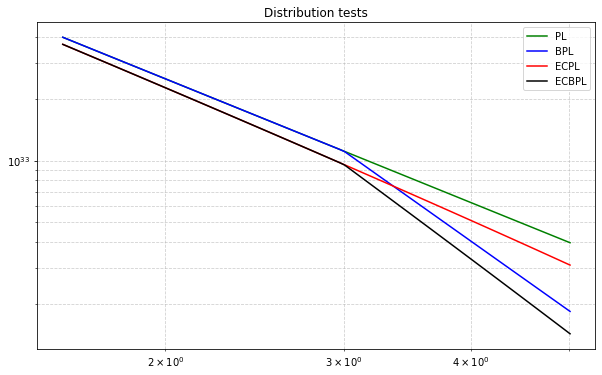

In [12]:
energy_values = np.logspace(0.2, 0.7, 100) * u.TeV  # Da 0.1 a 100 TeV

flux1=PL(energy_values)
flux2=BPL(energy_values)
flux3=ECPL(energy_values)
flux4=ECBPL(energy_values)

plt.figure(figsize=[10,6])
plt.plot(energy_values,flux1,color="green",label="PL")
plt.plot(energy_values,flux2,color="blue",label="BPL")
plt.plot(energy_values,flux3,color="red",label="ECPL")
plt.plot(energy_values,flux4,color="black",label="ECBPL")
plt.xscale('log')
#plt.ylim(1e-2,1e0)
plt.yscale('log')
plt.legend()
plt.title( r'Distribution tests')
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

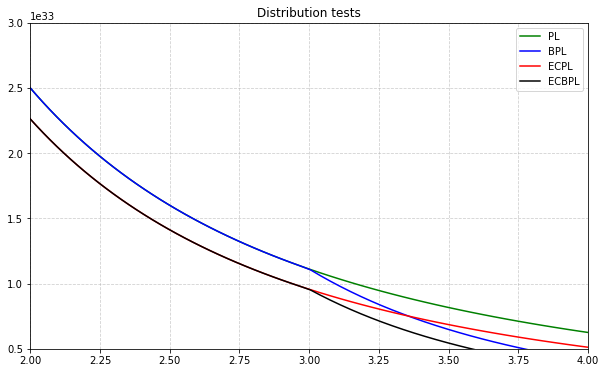

In [11]:
plt.figure(figsize=[10,6])
plt.plot(energy_values,flux1,color="green",label="PL")
plt.plot(energy_values,flux2,color="blue",label="BPL")
plt.plot(energy_values,flux3,color="red",label="ECPL")
plt.plot(energy_values,flux4,color="black",label="ECBPL")
#plt.xscale('log')
plt.xlim(2,4)
plt.ylim(0.5e33,3e33)
#plt.yscale('log')
plt.legend()
plt.title( r'Distribution tests')
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [16]:
import Radiative
#import naima
#from naima.models import (ExponentialCutoffPowerLaw,PowerLaw, Synchrotron,
#                          InverseCompton)

# Definiamo i parametri del modello
amplitude = 1e36 *u.Unit('1/eV')
e_0 = 1*u.TeV  # Energia di riferimento
alpha_1 = 2.1
alpha_2= 3.5

e_cut1=13*u.TeV
e_cut2=20*u.TeV

e_break= 3.0*u.TeV
B_field=100*u.uG

EPL = Models.PowerLaw(amplitude,e_0,alpha_1)
ECPL = Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut1)
ECPL2= Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut2)

SYN = Radiative.Synchrotron(EPL, B=B_field)
SYN2= Radiative.Synchrotron(ECPL, B=B_field)
SYN3= Radiative.Synchrotron(ECPL2, B=B_field)

ECBPL = Models.ExponentialCutoffPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2)
#ECBPL2= Models.ExponentialCutoffPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2,e_cutoff=e_cut2)
    #                  def __init__(self, amplitude, e_0, e_break, alpha_1, alpha_2, e_cutoff, beta=1.0):

SYN4= Radiative.Synchrotron(ECBPL, B=B_field)
#SYN5= Radiative.Synchrotron(ECBPL2, B=B_field)


# Compute SEDs
spectrum_energy = np.logspace(-1,14,1000)*u.eV
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN2 = SYN2.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN3 = SYN3.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN4 = SYN4.sed(spectrum_energy, distance=1.5*u.kpc)
#sed_SYN5 = SYN5.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(10,6))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync-PL',c="green")
plt.loglog(spectrum_energy,sed_SYN2,lw=2,label='Sync-ECPL',c="blue")
plt.loglog(spectrum_energy,sed_SYN3,lw=2,label='Sync-ECPL2',c="violet")

plt.loglog(spectrum_energy,sed_SYN4,lw=2,label='Sync-ECBPL1',c="black")
#plt.loglog(spectrum_energy,sed_SYN5,lw=2,label='Sync-ECBPL2',c="gray")

plt.axvline(e_cut.value, color='red', linestyle='--', label="Cutoff-1") 
plt.axvline(20, color='darkred', linestyle='--', label="Cutoff-2") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-13, 1e-4)
plt.xlim(1e0, 1e8)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests')

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

TypeError: Particle distribution should be given in units of differential energy

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
#rom naima.models import ExponentialCutoffBrokenPowerLaw, Synchrotron

# Parametri fissi
B_field = 100 * u.uG
e_break = 300 * u.GeV
e_0 = 1 * u.TeV
alpha_2 = 3.5
beta = 1.0
amplitude = 1e35 * u.Unit('1/eV')

# Griglia energia fotoni
energy = np.logspace(-3, 13, 300) * u.eV

# VARIA alpha_1
alphas = [1.8, 2.0, 2.3]

plt.figure(figsize=(8,6))

for a1 in alphas:
    model = Models.ExponentialCutoffBrokenPowerLaw(
        amplitude=amplitude,
        e_0=e_0,
        e_break=e_break,
        alpha_1=a1,
        alpha_2=alpha_2,
        e_cutoff=10 * u.TeV,
        beta=beta,
    )
    syn = Radiative.Synchrotron(model, B=B_field)
    sed = syn.sed(energy, distance=1.5 * u.kpc)
    plt.loglog(energy, sed, label=f'alpha1 = {a1}')

plt.xlabel("Photon Energy [eV]")
plt.ylabel("SED [erg / (s cm²)]")
plt.title("Synchrotron SED - varying alpha₁")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.ylim(1e-14, 1e-6)
plt.tight_layout()
plt.show()


TypeError: Particle distribution should be given in units of differential energy

<Figure size 576x432 with 0 Axes>

In [19]:


ECPL = Models.ExponentialCutoffPowerLaw(1e36*u.Unit('1/eV'), 1*u.TeV, 2.1, 13*u.TeV)
SYN = Radiative.Synchrotron(ECPL, B=100*u.uG)

# Define energy array for synchrotron seed photon field and compute
# Synchroton luminosity by setting distance to 0.
Esy = np.logspace(-6, 6, 100)*u.eV
Lsy = SYN.flux(Esy, distance=0*u.cm)

# Define source radius and compute photon density
R = 2 * u.pc
phn_sy = Lsy / (4 * np.pi * R**2 * c) * 2.26

# Create IC instance with CMB and synchrotron seed photon fields:
#IC = InverseCompton(ECPL, seed_photon_fields=['CMB', 'FIR', 'NIR',
#                                              ['SSC', Esy, phn_sy]])

# Compute SEDs
spectrum_energy = np.logspace(-1,14,100)*u.eV
#sed_IC = IC.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(8,5))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')
#ssc = IC.sed(spectrum_energy, seed='SSC', distance=1.5*u.kpc)
#plt.loglog(spectrum_energy,ssc,lw=1.5,
#        ls='-',label='IC (SSC)',c=naima.plot.color_cycle[2])
#for seed, ls in zip(['CMB','FIR','NIR'], ['-','--',':']):
#    sed = IC.sed(spectrum_energy, seed=seed, distance=1.5*u.kpc)
#    plt.loglog(spectrum_energy,sed,lw=1,
#            ls=ls,c='0.25')#,label='IC ({0})'.format(seed))

#plt.loglog(spectrum_energy,sed_IC,lw=2,
#        label='IC (total)',c=naima.plot.color_cycle[0])
plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c="green")
plt.xlabel('Photon energy [{0}]'.format(
        spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(
        sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-12, 1e-6)
plt.tight_layout()
plt.legend(loc='lower left')

TypeError: Particle distribution should be given in units of differential energy